# Exploratory Data Analysis (EDA): Late Shipments

**Goal:** Understand the structure, distribution, and key patterns in the shipping dataset to support model training and business insight.

This EDA investigates delivery delays by examining patterns in order characteristics, shipping mode, and product categories. The steps include:

1. **Loading and inspecting the raw dataset**
2. **Checking for missing values and duplicates**
3. **Creating delay indicators (late, very late)**
4. **Exploring delay patterns by shipping mode, region, and product**
5. **Evaluating correlations and removing redundant features**
6. **Visualizing the distribution of actual shipping times**
7. **Summarizing key findings to inform feature selection and modeling**

The analysis reveals that shipping mode has the strongest effect on delivery delays, while other features like order size and region show little variation. The findings help guide feature engineering and model design in the next phase.

## Import and Config
Import libraries, define the file paths for loading raw data, and configure plot styles.

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter-specific settings
%matplotlib inline

# Define project root
if "ipykernel" in sys.modules:
    from IPython import get_ipython
    notebook_path = Path(get_ipython().run_line_magic('pwd', '')).resolve()

    if notebook_path.name == "notebooks":
        base_dir = notebook_path.parent
    else:
        base_dir = notebook_path
else:
    base_dir = Path().resolve()

# Data file path
raw_data_file = base_dir / "data" / "raw" / "shipments_raw.csv"

# Plot settings
sns.set(style="whitegrid", palette="muted")

## Load Raw Data
Load the raw shipment data directly from CSV for initial exploration.

In [2]:
df = pd.read_csv(raw_data_file, encoding="latin1")

## Initial Inspection
Quick overview of the dataset's structure, data types, and a sample of the raw data.

In [3]:
print("🔹 Shape of the dataset:", df.shape)

print("\n🔹 DataFrame info:")
df.info()

print("\n🔹 First few rows:")
df.head()

print("\n🔹 Number of duplicated rows:", df.duplicated().sum())

🔹 Shape of the dataset: (180519, 53)

🔹 DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  object 
 9   Customer City                  180519 non-null  object 
 10  Customer Country               180519 non-null  object 
 11  Customer Email                 1805

## Missing Values
Check for missing values across all columns in the dataset.

In [4]:
print("\n🔹 Missing values per column:")
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

if not missing.empty:
    print(missing)
else:
    print("✅ No missing values detected.")


🔹 Missing values per column:
Product Description    180519
Order Zipcode          155679
Customer Lname              8
Customer Zipcode            3
dtype: int64


## Target Variable Construction
Create binary indicators for late and very late shipments:
- **Late orders**: Orders where the actual shipping time exceeds the scheduled shipping time.
- **Very late orders**: Orders where the actual shipping time exceeds the scheduled time by **3 days or more**.

In [5]:
df['late'] = (df['Days for shipping (real)'] > df['Days for shipment (scheduled)']).astype(int)
df['very_late'] = (df['Days for shipping (real)'] > (df['Days for shipment (scheduled)'] + 2)).astype(int)

## Target Distribution
Display the frequency and proportion of late and very late shipments to understand class balance for both target variables.

In [6]:
late_counts = df['late'].value_counts()
late_percent = df['late'].value_counts(normalize=True)*100
print("Late Order Distribution:")
print(f"Not Late (0): {late_counts[0]} ({late_percent[0]:.2f}%)")
print(f"Late (1): {late_counts[1]} ({late_percent[1]:.2f}%)")

very_late_counts = df['very_late'].value_counts()
very_late_percent = df['very_late'].value_counts(normalize=True)*100
print("\nVery Late Order Distribution:")
print(f"Not Very Late (0): {very_late_counts[0]} ({very_late_percent[0]:.2f}%)")
print(f"Very Late (1): {very_late_counts[1]} ({very_late_percent[1]:.2f}%)")


Late Order Distribution:
Not Late (0): 77119 (42.72%)
Late (1): 103400 (57.28%)

Very Late Order Distribution:
Not Very Late (0): 166484 (92.23%)
Very Late (1): 14035 (7.77%)


## Feature Distribution
This section first flags features that are high cardinality, identifier-like, or may reveal customer identity. The remaining features are then explored in more depth to better understand their distribution and modeling relevance.

### Overview of Feature Types
A summary of each feature’s data type, number of unique values, and missing values.

In [7]:
feature_summary = pd.DataFrame({
    'Feature': df.columns,
    'Num_Unique': [df[col].nunique() for col in df.columns],
    'Data_Type': [df[col].dtype for col in df.columns],
    'Missing_Values': [df[col].isna().sum() for col in df.columns]
})

feature_summary.head(10)

,Feature,Num_Unique,Data_Type,Missing_Values
0,Type,4,object,0
1,Days for shipping (real),7,int64,0
2,Days for shipment (scheduled),4,int64,0
3,Benefit per order,21998,float64,0
4,Sales per customer,2927,float64,0
5,Delivery Status,4,object,0
6,Late_delivery_risk,2,int64,0
7,Category Id,51,int64,0
8,Category Name,50,object,0
9,Customer City,563,object,0


### High Cardinality Categorical Features
Flags features with more than 500 unique values and a categorical or integer data type, which may cause issues in encoding or add little modeling value.

In [8]:
feature_summary['High_Cardinality_Cat'] = [
    (
        df[col].nunique() > 500 and
        (
            df[col].dtype == 'object' or
            df[col].dtype.name == 'category' or
            pd.api.types.is_integer_dtype(df[col])
        )
    )
    for col in df.columns
]

print(feature_summary[feature_summary['High_Cardinality_Cat']])


                       Feature  ...  High_Cardinality_Cat
9                Customer City  ...                  True
12              Customer Fname  ...                  True
13                 Customer Id  ...                  True
14              Customer Lname  ...                  True
18             Customer Street  ...                  True
25                  Order City  ...                  True
27           Order Customer Id  ...                  True
28     order date (DateOrders)  ...                  True
29                    Order Id  ...                  True
33               Order Item Id  ...                  True
41                 Order State  ...                  True
51  shipping date (DateOrders)  ...                  True

[12 rows x 5 columns]


### Identifier and Customer-Linked Feature Detection
Flags features that likely contain unique identifiers or sensitive customer information. These features typically provide no predictive value and may introduce data leakage or privacy risks.

In [9]:
risky_identifier_features = [
    # Explicit order/customer/product IDs
    'Order Id',
    'Order Item Id',
    'Order Item Cardprod Id',
    'Order Customer Id',
    'Customer Id',
    'Product Card Id',
    'Product Category Id',
    'Category Id',
    'Department Id',

    # Personally identifiable info (PII)
    'Customer Email',
    'Customer Fname',
    'Customer Lname',
    'Customer Password',
    'Customer Street',
    'Customer Zipcode',
    'Order Zipcode',

    # Possibly geo-identifying or too granular
    'Latitude',
    'Longitude',

    # Product/media identifiers or non-descriptive fields
    'Product Image',
    'Product Description',  # Also contains 0 non-null values
]

feature_summary['Manually_Flagged_Identifier'] = feature_summary['Feature'].isin(risky_identifier_features)

### Combined Risk Flag: High Cardinality or Identifier Features
Flags features that are either high cardinality or manually identified as likely to contain unique or sensitive information. These features are often excluded during modeling to avoid data leakage or poor generalization.

In [10]:
feature_summary['Flagged_Risky'] = (
    feature_summary['High_Cardinality_Cat'] | feature_summary['Manually_Flagged_Identifier']
)

flagged_features = feature_summary[feature_summary['Flagged_Risky']][
    ['Feature', 'Data_Type', 'Num_Unique', 'High_Cardinality_Cat', 'Manually_Flagged_Identifier']
]

flagged_features.sort_values(by='Feature').reset_index(drop=True)

,Feature,Data_Type,Num_Unique,High_Cardinality_Cat,Manually_Flagged_Identifier
0,Category Id,int64,51,False,True
1,Customer City,object,563,True,False
2,Customer Email,object,1,False,True
3,Customer Fname,object,782,True,True
4,Customer Id,int64,20652,True,True
5,Customer Lname,object,1109,True,True
6,Customer Password,object,1,False,True
7,Customer Street,object,7458,True,True
8,Customer Zipcode,float64,995,False,True
9,Department Id,int64,11,False,True


### Correlation Analysis of Non-Flagged Features
This section examines correlations among features that were not flagged as risky (i.e., not identifiers or high-cardinality). Highly correlated features may carry redundant information and might not be well suited to train the model.

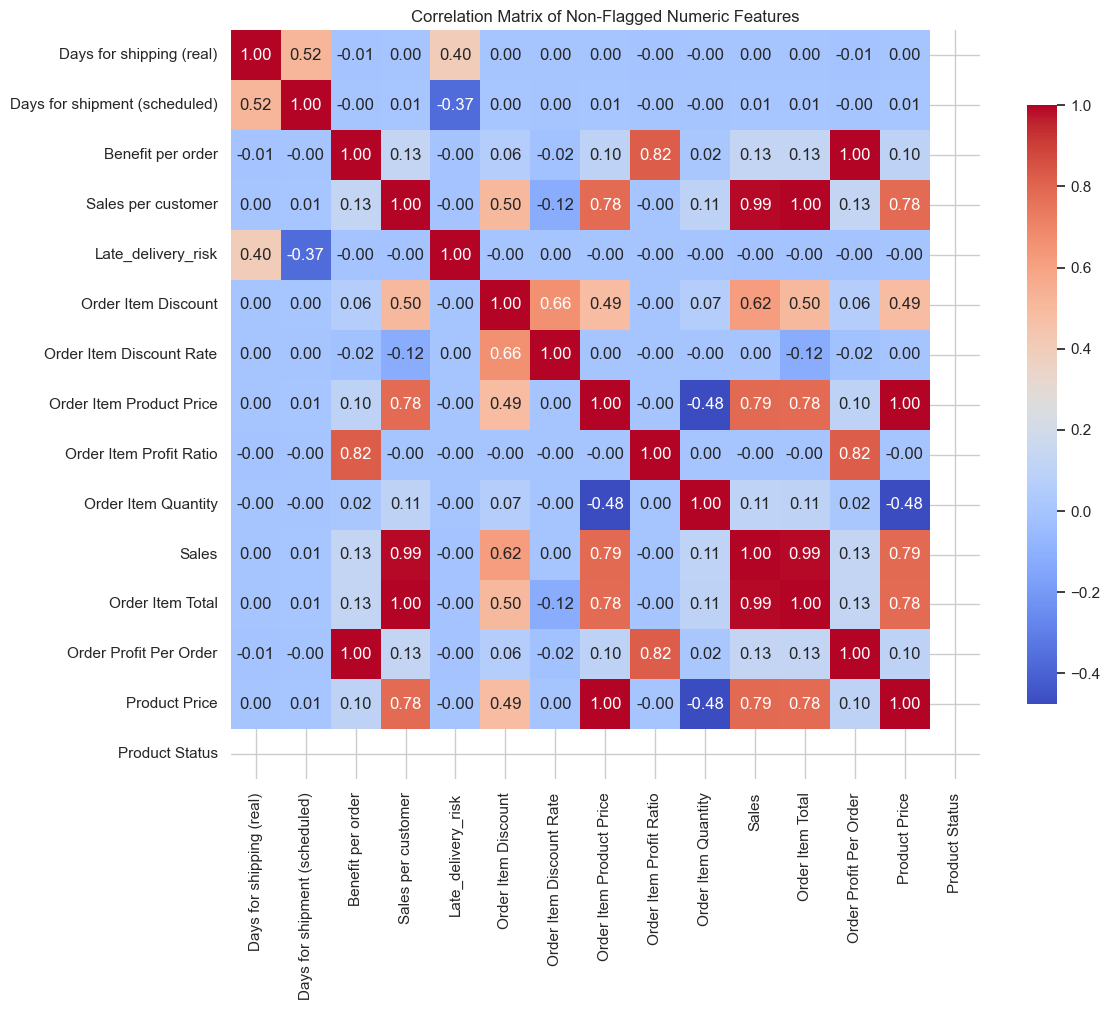

In [11]:
# Select only non-flagged features
non_flagged_features = feature_summary.loc[~feature_summary['Flagged_Risky'], 'Feature'].tolist()

# Filter the original DataFrame to include only non-flagged features
df_non_flagged = df[non_flagged_features]

# Keep only numeric columns for correlation
numeric_cols = df_non_flagged.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Compute the correlation matrix
correlation_matrix = df_non_flagged[numeric_cols].corr()

# Plot heatmap using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": 0.8})
plt.title("Correlation Matrix of Non-Flagged Numeric Features")
plt.tight_layout()
plt.show()

# 'Order Item Product Price', 'Sales', and 'Benefit per order' are perfectly or nearly perfectly correlated with other variables.
correlated_features = ['Order Item Product Price', 'Sales', 'Benefit per order']

# Keep non-flagged and uncorrelated features
df_cleaned = df_non_flagged.drop(columns=correlated_features)


### Final Feature Selection
This section removes columns that are not suitable for model training, retaining only the potentially predictive features for further exploration.:

- **late** and **very_late** are the target variables and not used as predictors.
- **Product Status** is a constant of zeros and provides no useful information.  
- **Late_delivery_risk** captures the target the models are meant to predict, which would cause data leakage.
- **Days for shipping (real)** captures delivery outcomes, which would cause data leakage.
- **Order Item Discount** and **Order Item Discount Rate** may cause leakage, as discounts could be applied retroactively if shipments are delayed.

In [12]:
df_model_features = df_cleaned.drop(columns=[
    'late',
    'very_late',
    'Product Status',
    'Late_delivery_risk',
    'Days for shipping (real)',
    'Order Item Discount',
    'Order Item Discount Rate'
])

print("🔍 Features retained for further analysis")
print(df_model_features.columns.tolist())

🔍 Features retained for further analysis
['Type', 'Days for shipment (scheduled)', 'Sales per customer', 'Delivery Status', 'Category Name', 'Customer Country', 'Customer Segment', 'Customer State', 'Department Name', 'Market', 'Order Country', 'Order Item Profit Ratio', 'Order Item Quantity', 'Order Item Total', 'Order Profit Per Order', 'Order Region', 'Order Status', 'Product Name', 'Product Price', 'Shipping Mode']


### Summary Statistics for Numerical Features

In [13]:
df_model_features.describe().round(2)

,Days for shipment (scheduled),Sales per customer,Order Item Profit Ratio,Order Item Quantity,Order Item Total,Order Profit Per Order,Product Price
count,180519.00,180519.00,180519.00,180519.00,180519.00,180519.00,180519.00
mean,2.93,183.11,0.12,2.13,183.11,21.97,141.23
std,1.37,120.04,0.47,1.45,120.04,104.43,139.73
min,0.00,7.49,-2.75,1.00,7.49,-4274.98,9.99
25%,2.00,104.38,0.08,1.00,104.38,7.00,50.00
50%,4.00,163.99,0.27,1.00,163.99,31.52,59.99
75%,4.00,247.40,0.36,3.00,247.40,64.80,199.99
max,4.00,1939.99,0.50,5.00,1939.99,911.80,1999.99


### Visual Distribution of Numerical Features
This section shows histograms of selected numerical features, with extreme outliers (below the 1st and above the 99th percentile) removed to better visualize the typical data range.

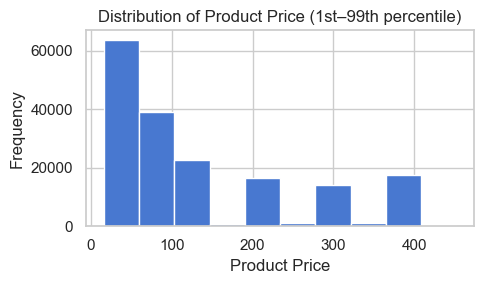

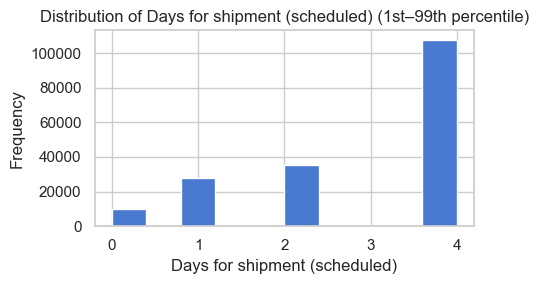

In [14]:
# List of numerical features
num_features = [
    'Days for shipment (scheduled)',
    'Sales per customer',
    'Order Item Profit Ratio',
    'Order Item Quantity',
    'Order Item Total',
    'Order Profit Per Order',
    'Product Price'
]

selected_num_features = ['Product Price', 'Days for shipment (scheduled)']

# Plot histograms with default binning for selected features
for feature in selected_num_features:
    # Drop NaNs
    data = df_model_features[feature].dropna()
    
    # Trim outliers based on percentiles
    lower_bound = data.quantile(0.01)
    upper_bound = data.quantile(0.99)
    trimmed_data = data[(data >= lower_bound) & (data <= upper_bound)]
    
    # Plot trimmed histogram
    plt.figure(figsize=(5, 3))
    trimmed_data.hist()
    plt.title(f'Distribution of {feature} (1st–99th percentile)')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()


### Frequency of Categorical Features
This section summarizes the number of unique categories for each non-numeric feature and visualizes the top 5 most frequent categories for selected features. Long labels are truncated for readability in the plots.

Nr of Categorical Values of Non-Numeric Features:
Type 4
Delivery Status 4
Category Name 50
Customer Country 2
Customer Segment 3
Customer State 46
Department Name 11
Market 5
Order Country 164
Order Region 23
Order Status 9
Product Name 118
Shipping Mode 4



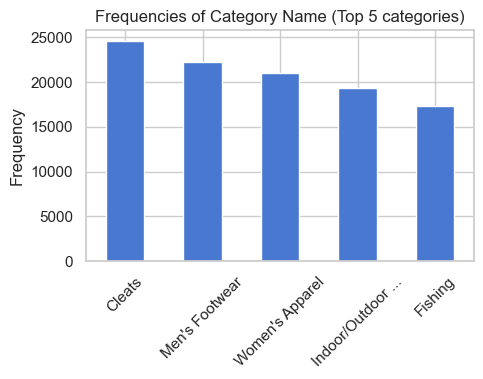

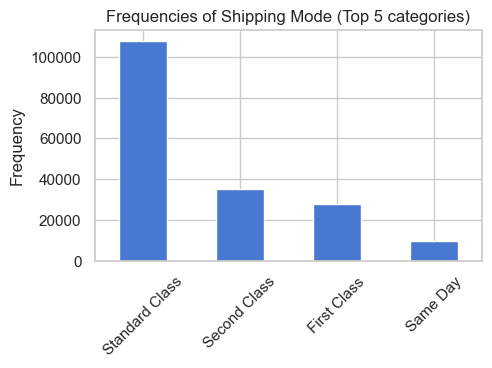

In [15]:
df_non_numeric_features = df_model_features.select_dtypes(exclude='number')

print("Nr of Categorical Values of Non-Numeric Features:")
for col in df_non_numeric_features:
    print(col, df_model_features[col].nunique())
print("")

selected_non_numeric_features = ['Category Name', 'Shipping Mode']

for col in selected_non_numeric_features:
    values = df_model_features[col].value_counts()
    top_values = values[:5]
    for index_val in top_values.index:
        if len(index_val) > 15:
            top_values = top_values.rename(index={index_val: index_val[:15] + "..."})
    
    plt.figure(figsize=(5, 3))
    top_values.plot(kind='bar')
    plt.title(f'Frequencies of {col} (Top 5 categories)')
    plt.xlabel("")
    plt.ylabel('Frequency')
    plt.xticks(rotation=45) 
    plt.show()


### Categorical Overview
This section provides an exploratory analysis of how the share of late and very late shipments varies across key categorical features:

- **Shipping Mode**
- **Order Region**
- **Product Category**
- **Order Composition**  
  (number of unique items, total quantity, and total value per order)

The purpose is to uncover patterns and potential relationships that could inform feature selection and improve model performance in predicting late deliveries.

#### Share of Late and Very Late Shipments by Mode of Shipping

In [16]:
# Keep complete orders
df_complete = df_cleaned[df_cleaned['Order Status'].isin(['COMPLETE', 'CLOSED'])]

# Display Share of Late and Very Late Shipments by Mode of Shipping
late_by_mode = []
tot_obs = df_complete['Shipping Mode'].notna().sum()
for mode in df_complete['Shipping Mode'].dropna().unique():
    mode_subset = df_complete[df_complete['Shipping Mode'] == mode]
    share_late = mode_subset['late'].mean()
    share_very_late = mode_subset['very_late'].mean()
    share_obs = len(mode_subset)/tot_obs
    
    row = {
        "Mode of Shipment": mode,
        "Share Late": f"{share_late * 100:.2f}",
        "Share Very Late": f"{share_very_late * 100:.2f}",
        "Share obs.": f"{share_obs * 100:.2f}"
    }
    late_by_mode.append(row)

df_late_by_mode = pd.DataFrame(late_by_mode)

print("="*60)
print("Share of Late and Very Late Shipments by Mode of Shipping")
print("="*60 + "\n")
print(df_late_by_mode.to_string(index=False) + "\n")

Share of Late and Very Late Shipments by Mode of Shipping

Mode of Shipment Share Late Share Very Late Share obs.
  Standard Class      39.59            0.00      59.46
     First Class     100.00            0.00      15.58
    Second Class      79.54           38.13      19.54
        Same Day      48.23            0.00       5.42



#### Share of Late and Very Late Shipments by Order Region

In [17]:
# Display Share of Late and Very Late Shipments by Order Region
late_by_region = []
tot_obs = df_complete['Order Region'].notna().sum()
for region in df_complete['Order Region'].dropna().unique():
    region_subset = df_complete[df_complete['Order Region'] == region]
    share_late = region_subset['late'].mean()
    share_very_late = region_subset['very_late'].mean()
    share_obs = len(region_subset)/tot_obs
    
    row = {
        "Order Region": region,
        "Share Late": f"{share_late * 100:.2f}",
        "Share Very Late": f"{share_very_late * 100:.2f}",
        "Share obs.": f"{share_obs * 100:.2f}"
    }
    late_by_region.append(row)

df_late_by_region = pd.DataFrame(late_by_region)

print("="*60)
print("Share of Late and Very Late Shipments by Order Region")
print("="*60 + "\n")
print(df_late_by_region.to_string(index=False) + "\n")

Share of Late and Very Late Shipments by Order Region

   Order Region Share Late Share Very Late Share obs.
 Southeast Asia      58.69            6.79       5.14
     South Asia      60.04            9.02       4.25
        Oceania      55.74            7.42       5.71
   Eastern Asia      57.76            8.02       3.88
Southern Europe      57.08            7.57       5.29
 Western Europe      58.54            7.79      14.86
Northern Europe      56.79            7.73       5.49
      West Asia      58.95            6.89       3.21
   Central Asia      59.70           11.19       0.34
    West Africa      54.28            8.03       2.16
 Central Africa      56.54            5.72       0.99
    East Africa      58.53            7.71       1.00
Southern Africa      56.95            6.10       0.66
   North Africa      56.63            7.10       1.75
 Eastern Europe      58.97            5.69       2.29
      Caribbean      54.97            7.22       4.57
Central America      55.85 

#### Share of Late and Very Late Shipments by Category Name

In [18]:
# Display Share of Late and Very Late Shipments by Category Name
late_by_category = []
tot_obs = df_complete['Category Name'].notna().sum()
for category in df_complete['Category Name'].dropna().unique():
    category_subset = df_complete[df_complete['Category Name'] == category]
    share_late = category_subset['late'].mean()
    share_very_late = category_subset['very_late'].mean()
    share_obs = len(category_subset)/tot_obs
    
    row = {
        "Category Name": category,
        "Share Late": f"{share_late * 100:.2f}",
        "Share Very Late": f"{share_very_late * 100:.2f}",
        "Share obs.": f"{share_obs * 100:.2f}"
    }
    late_by_category.append(row)

df_late_by_category = pd.DataFrame(late_by_category)

print("="*60)
print("Share of Late and Very Late Shipments by Category Name")
print("="*60 + "\n")
print(df_late_by_category.to_string(index=False) + "\n")

Share of Late and Very Late Shipments by Category Name

       Category Name Share Late Share Very Late Share obs.
      Sporting Goods      62.58            7.10       0.20
Consumer Electronics      57.64           10.34       0.26
            Cameras       60.78            7.06       0.32
           Computers      53.14            8.21       0.26
          Basketball      58.33           12.50       0.03
              Soccer      54.10           11.48       0.08
 Baseball & Softball      55.87            8.54       0.36
         Electronics      59.36            6.86       1.70
    Cardio Equipment      57.33            6.69       6.99
      Men's Footwear      56.44            7.33      12.44
              Cleats      58.09            7.62      13.51
    Women's Clothing      61.97           13.03       0.36
              Crafts      59.91            8.11       0.28
      Men's Clothing      53.49            2.33       0.11
     Women's Apparel      56.58            7.44      11.75


#### Overview of Late Shipment Rates by Order Characteristics

This section presents the percentage of late and very late shipments, grouped by key order characteristics:

- **Number of unique items per order**  
- **Total quantity of items per order**  
- **Total order value**

The purpose is to identify whether certain types of orders are more prone to delays, providing insight into potential risk factors in the order fulfillment process.


In [19]:
# Compare if Large vs Small Orders are more delayed

# Keep complete orders from full data frame
df_full_complete = df[df['Order Status'].isin(['COMPLETE', 'CLOSED'])].copy()

df_full_complete['Value'] = df_full_complete['Product Price'] * df_full_complete['Order Item Quantity']

# Compute uniqie items per, total items per order, and total value per order
df_order_groups = df_full_complete.groupby('Order Id').agg(
    Unique_Item_Count = ('Order Item Id', 'nunique'),
    Total_Item_Count = ('Order Item Quantity', 'sum'),
    Total_Value_Sum = ('Value', 'sum'),
    Late = ('late', 'first'),
    Very_Late = ('very_late', 'first')
)

# Group uniqie items per
df_order_groups['Unique_Items'] = pd.qcut(
    df_order_groups['Unique_Item_Count'],
    q=3,
    labels=['Few','Average','Many']
)

# Group total items per order
df_order_groups['Total_Items'] = pd.qcut(
    df_order_groups['Total_Item_Count'],
    q=3,
    labels=['Few','Average','Many']
)

# Group total value per order
df_order_groups['Total_Value'] = pd.qcut(
    df_order_groups['Total_Value_Sum'],
    q=3,
    labels=['Low','Medium','High']
)

# Compare share of late and vary late orders depending on nr of unique items in order
unique_orders = df_order_groups.groupby('Unique_Items', observed=True).agg({
    'Late': 'mean',
    'Very_Late': 'mean'
})

unique_orders.rename(columns={
    'Late': 'Share Late',
    'Very_Late': 'Share Very Late'
}, inplace=True)

unique_orders['Share Late'] = (unique_orders['Share Late'] * 100).round(2)
unique_orders['Share Very Late'] = (unique_orders['Share Very Late'] * 100).round(2)

print("="*60)
print("Late Shipment Rates by Unique Item Count per Order (%)")
print("="*60 + "\n")
print(unique_orders.to_string(index=True, index_names=False))


# Compare share of late and vary late orders depending on total nr of items in order
total_items_orders = df_order_groups.groupby('Total_Items', observed=True).agg({
    'Late': 'mean',
    'Very_Late': 'mean'
})

total_items_orders.rename(columns={
    'Late': 'Share Late',
    'Very_Late': 'Share Very Late'
}, inplace=True)

total_items_orders['Share Late'] = (total_items_orders['Share Late'] * 100).round(2)
total_items_orders['Share Very Late'] = (total_items_orders['Share Very Late'] * 100).round(2)

print("\n" + "="*60)
print("Late Shipment Rates by Total Item Count per Order (%)")
print("="*60 + "\n")
print(total_items_orders.to_string(index=True, index_names=False))

# Compare share of late and vary late orders depending on total value of an order
total_value_orders = df_order_groups.groupby('Total_Value', observed=True).agg({
    'Late': 'mean',
    'Very_Late': 'mean'
})

total_value_orders.rename(columns={
    'Late': 'Share Late',
    'Very_Late': 'Share Very Late'
}, inplace=True)

total_value_orders['Share Late'] = (total_value_orders['Share Late'] * 100).round(2)
total_value_orders['Share Very Late'] = (total_value_orders['Share Very Late'] * 100).round(2)

print("\n" + "="*60)
print("Late Shipment Rates by Total Value of Order (%)")
print("="*60 + "\n")
print(total_value_orders.to_string(index=True, index_names=False))



Late Shipment Rates by Unique Item Count per Order (%)

         Share Late  Share Very Late
Few           57.63             7.80
Average       57.09             7.67
Many          57.52             6.89

Late Shipment Rates by Total Item Count per Order (%)

         Share Late  Share Very Late
Few           57.37             7.71
Average       57.97             7.69
Many          56.95             7.38

Late Shipment Rates by Total Value of Order (%)

        Share Late  Share Very Late
Low          57.77             7.75
Medium       57.81             7.64
High         56.69             7.41


### Shipping Time Comparison
#### Shipping Time Distribution for Late and On-Time Orders
This section displays the shipping time distributions for orders that are on time, late, and very late.

Average Delivery Time by Delay Group
On Time: 2.71 days
Late: 3.85 days
Very Late: 5.50 days



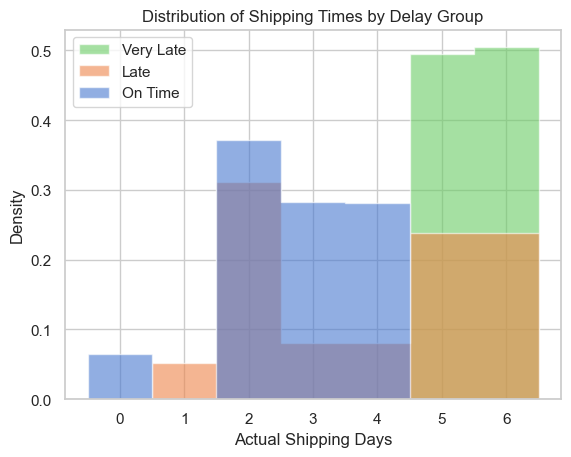

In [20]:
# Collapse data to shipment level
#(Note: Scheduled shipping time and shipping mode does not vary within an order)
df_orders = df_full_complete.groupby('Order Id').agg({
    'Days for shipment (scheduled)': 'first',
    'Days for shipping (real)': 'first'
})

# Create a days delayed column
df_orders['days_delayed'] = df_orders['Days for shipping (real)']-df_orders['Days for shipment (scheduled)']

# Categorize days delayed
df_orders['delay_group'] = pd.cut(
    df_orders['days_delayed'],
    bins=[-float('inf'), 0, 2, float('inf')],
    labels=['On Time', 'Late', 'Very Late']
)

# Display average shipping time by delay group
print("="*50)
print("Average Delivery Time by Delay Group")
print("="*50)
for group in df_orders['delay_group'].unique():
    mean_delay=df_orders['Days for shipping (real)'][df_orders['delay_group']==group].mean()
    print(f"{group}: {mean_delay:.2f} days")
print("")

# Create and overlay histograms

# Create subsets of series
on_time = df_orders[df_orders['delay_group'] == 'On Time']['Days for shipping (real)']
late = df_orders[df_orders['delay_group'] == 'Late']['Days for shipping (real)']
very_late = df_orders[df_orders['delay_group'] == 'Very Late']['Days for shipping (real)']

# Plot all three histograms together
bins = np.arange(-0.5, 7.5, 1) 

plt.hist(
    [on_time, late, very_late],
    bins=bins,
    label=['On Time', 'Late', 'Very Late'],
    alpha=0.6,
    density=True,
    histtype='stepfilled'
)

plt.xlabel('Actual Shipping Days')
plt.ylabel('Density')
plt.title('Distribution of Shipping Times by Delay Group')
plt.legend()
plt.grid(True)
plt.show()



## Key Findings

- The feature identifying late shipments is balanced, while the feature identifying very late shipments is highly imbalanced.
- Shipping mode strongly influences the likelihood of delays:
    - Second Class delivery is the only mode associated with very late shipments.
    - First Class delivery is never categorized as very late, but all such shipments are classified as late.
    - Shipments using Second Class are late in 80% of cases, compared to 40% for Standard and 48% for Same Day delivery.
- The likelihood of a shipment being late or very late varies very little across order regions or product categories.
- Shipment delays also show minimal variation based on order characteristics, including the number of unique items, the total number of items, and the total value of the order.
- Actual shipping time ranges from zero to six days. On-time shipments average 2.7 days, while late and very late shipments average 3.9 and 5.5 days, respectively.